In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as spicystats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from pandas.plotting import scatter_matrix
import statsmodels.api as sm

import sys
sys.path.insert(0, 'src/')
import functions
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# load and clean dataset, changed fico range from a string to an integer ranked order, train-test split

loan_data = pd.read_csv('data/loan_data.csv')
loan_data['amount_funded_by_investors'].replace(-0.01, 0.00, inplace=True)

X = loan_data.drop('interest_rate', axis=1)
y = loan_data['interest_rate']

fico_dict = {idx+1:val for idx, val in enumerate(np.sort(X.fico_range.unique()))}
fico_df = pd.DataFrame([fico_dict]).T.rename(columns={0: 'fico_range'})
fico_df['fico_score'] = [float(i[:3]) for i in fico_df['fico_range']]

X = X.merge(fico_df, 'left', on='fico_range').drop('fico_range', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
# sns.pairplot(X_train)

In [ ]:
# creating linear regression model 1 and printing summary info

y_hat = functions.linear_regression_model(X_train, y_train, X_test)
functions.model_summary(y_train, X_train)

In [47]:
# RMSE for model 1

functions.rmse(y_test, y_hat)

2.025904878556023

In [48]:
# RMSE of training and test set with K-folds for model 1

functions.cross_val_linear(X_train, y_train, 5)

(2.1235170893093605, 2.131015136841591)

In [ ]:
# Residual plot for each individual feature

fig, ax = plt.subplots(4,1)

for idx, val in enumerate(X_test.columns):
    functions.residual_plot(ax[idx], X_test[val], y_test, y_hat)

In [ ]:
# Residual plot for entire model 1

fig, ax = plt.subplots()
functions.residual_plot(ax, X_test.index, y_test, y_hat)

In [ ]:
# Model 2 Dataframe Creation

X2 = X[['amount_funded_by_investors', 'loan_length', 'fico_score']]
y2 = y
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2)

In [ ]:
# creating linear regression model 2 and printing summary info

y2_hat = functions.linear_regression_model(X2_train, y2_train, X2_test)
functions.model_summary(y2_train, X2_train)

In [72]:
# RMSE for model 2

functions.rmse(y2_test, y2_hat)

2.0937902076652386

In [73]:
# RMSE of training and test set with K-folds for model 2

functions.cross_val_linear(X2_train, y2_train, 5)

(2.1109066988591048, 2.117040132518013)

In [ ]:
# Residual plot for each individual feature model 2

fig, ax = plt.subplots(3,1)
fig.tight_layout()

for idx, val in enumerate(X2_test.columns):
    functions.residual_plot(ax[idx], X2_test[val], y2_test, y2_hat)

In [ ]:
# Residual plot for entire model 2

fig, ax = plt.subplots()
functions.residual_plot(ax, X2_test.index, y2_test, y2_hat)

In [78]:
# Model 3 DataFrame Creation

X_train_norm, y_train_norm, X_test_norm, y_test_norm = functions.normalize_data(X, y)

In [82]:
# RMSE of training and test set using Ridge regression for model 2

functions.cross_val_ridge(X_train_norm, y_train_norm, 3, alpha=0.01)

(0.10902262000619693, 0.1091804804931275)

In [ ]:
# training Ridge regression model at various alpha values to find minimum RMSE on test set

ridge_alphas = np.logspace(-2, 0.2, num=100)

ridge_cv_errors_train, ridge_cv_errors_test = functions.train_at_various_alphas(X_train_norm, y_train_norm, model=Ridge, alphas=ridge_alphas)

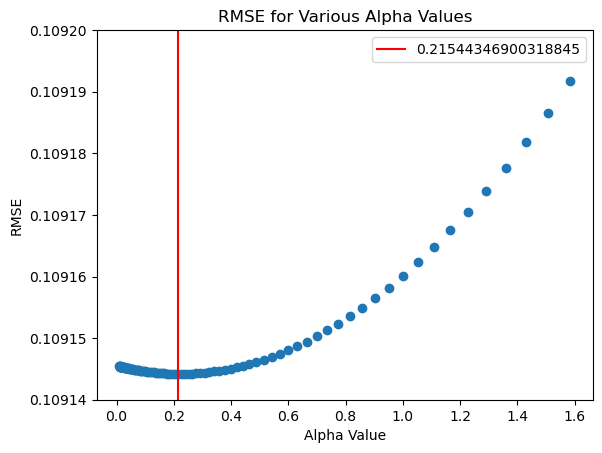

In [115]:
# plotting range of alpha values to find minimum RMSE

plt.scatter(ridge_cv_errors_test.index, ridge_cv_errors_test.values)
plt.axvline(ridge_cv_errors_test.idxmin(), color='r', label=ridge_cv_errors_test.idxmin())
plt.ylim(0.10914,0.10920)
plt.title('RMSE for Various Alpha Values')
plt.xlabel('Alpha Value')
plt.ylabel('RMSE')
plt.legend()